In [61]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from glob import glob

In [62]:
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")
mouth_cascade = cv2.CascadeClassifier("haarcascade_mcs_mouth.xml")
nose_cascade = cv2.CascadeClassifier("haarcascade_mcs_nose.xml")

In [63]:
def loadData(path):
    
    def getInfo(file):
        try:
            tmp = file.split('\\')[-1].split('_')
            age = tmp[0]
            file = file.replace('\\', '/')
            # name = tmp[-1]
            return int(age), file
        except:
            return None, None
    
    
    files = glob(path)
    
    record = []
    
    for file in files:
        info = getInfo(file)
        record.append(info)
    
    df = pd.DataFrame(record)
    
    df.columns = ['age', 'file']
    
    return df


df = loadData('UTKFace\\*.jpg')
# df2 = loadData('UTKFace\\part2\\*.jpg')
# df3 = loadData('UTKFace\\part3\\*.jpg')

In [64]:
# df = pd.concat([df1, df2])
# df = pd.concat([df, df3])
# df = df1
df = df[:10000]
df

,age,file
0,100,UTKFace/100_0_0_20170112213500903.jpg
1,100,UTKFace/100_0_0_20170112215240346.jpg
2,100,UTKFace/100_1_0_20170110183726390.jpg
3,100,UTKFace/100_1_0_20170112213001988.jpg
4,100,UTKFace/100_1_0_20170112213303693.jpg
...,...,...
9995,29,UTKFace/29_1_0_20170109132341425.jpg
9996,29,UTKFace/29_1_0_20170109134017138.jpg
9997,29,UTKFace/29_1_0_20170109134431956.jpg
9998,29,UTKFace/29_1_0_20170111182452813.jpg


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     10000 non-null  int64 
 1   file    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [66]:
df.isnull().sum()

age     0
file    0
dtype: int64

In [67]:
df.describe()

,age
count,10000.000000
mean,20.823900
std,9.969706
min,1.000000
25%,18.000000
50%,24.000000
75%,26.000000
max,116.000000


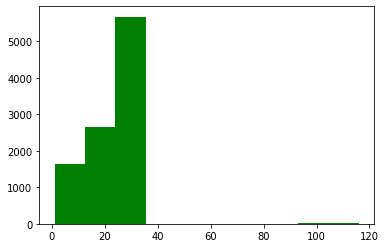

In [68]:
ages = df['age']
nbins = 10
plt.hist(ages, nbins, color='green', histtype='bar')
plt.show()

In [69]:
df['age_group'] = df['age']//10
groups = df.groupby('age_group')
OUTPUT_SHAPE = len(groups.groups.keys())

In [70]:
TRAIN_RATIO = 0.8
WIDTH = HEIGHT = 100

In [71]:
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_RATIO)      
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]
print(train_idx, val_idx)

[4000 5776 1095 ... 4406 3370 3822] [8082 4447 5737 ... 4460 1546 9276]


In [72]:
def readImage(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = np.array(image) / 255.0
    
    return image

def createImageData(image_idx, df, batch_size=16):
    
    images, ages = [], []
    
    for idx in image_idx:
        tmp = df.iloc[idx]
        
        age = tmp['age_group']
        path = tmp['file']
        
        image = readImage(path)
        
        images.append(image)
        ages.append(age)
    return np.array(images), np.array(ages)
        
    # if len(images) >= batch_size:
    #     yield np.array(images), np.array(ages)
    #     images, ages = [], []

In [73]:
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

In [74]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    device=physical_devices[0], enable=True)

# tf.config.experimental.set_virtual_device_configuration(
#     physical_devices[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])

In [75]:
# def res_identity(x, filters):
#     # renet block where dimension doesnot change.
#     # The skip connection is just simple identity conncection
#     # we will have 3 blocks and then input will be added

#     x_skip = x  # this will be used for addition with the residual block
#     f1, f2 = filters

#     # first block
#     x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1),
#                padding='valid', kernel_regularizer=l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Activation(activations.relu)(x)

#     # second block # bottleneck (but size kept same with padding)
#     x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1),
#                padding='same', kernel_regularizer=l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Activation(activations.relu)(x)

#     # third block activation used after adding the input
#     x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1),
#                padding='valid', kernel_regularizer=l2(0.001))(x)
#     x = BatchNormalization()(x)
#     # x = Activation(activations.relu)(x)

#     # add the input
#     x = Add()([x, x_skip])
#     x = Activation(activations.relu)(x)

#     return x

# def res_conv(x, s, filters):
#     '''
#     here the input size changes'''
#     x_skip = x
#     f1, f2 = filters

#     # first block
#     x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s),
#                padding='valid', kernel_regularizer=l2(0.001))(x)
#     # when s = 2 then it is like downsizing the feature map
#     x = BatchNormalization()(x)
#     x = Activation(activations.relu)(x)

#     # second block
#     x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1),
#                padding='same', kernel_regularizer=l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Activation(activations.relu)(x)

#     # third block
#     x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1),
#                padding='valid', kernel_regularizer=l2(0.001))(x)
#     x = BatchNormalization()(x)

#     # shortcut
#     x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s),
#                     padding='valid', kernel_regularizer=l2(0.001))(x_skip)
#     x_skip = BatchNormalization()(x_skip)

#     # add
#     x = Add()([x, x_skip])
#     x = Activation(activations.relu)(x)

#     return x

# def resnet50(output_shape):

#     input_im = Input(shape=(WIDTH, HEIGHT, 3))
#     x = ZeroPadding2D(padding=(3, 3))(input_im)

#     # 1st stage
#     # here we perform maxpooling, see the figure above

#     x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
#     x = BatchNormalization()(x)
#     x = Activation(activations.relu)(x)
#     x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#     # 2nd stage
#     # frm here on only conv block and identity block, no pooling

#     x = res_conv(x, s=1, filters=(64, 256))
#     x = res_identity(x, filters=(64, 256))
#     x = res_identity(x, filters=(64, 256))

#     # 3rd stage

#     x = res_conv(x, s=2, filters=(128, 512))
#     x = res_identity(x, filters=(128, 512))
#     x = res_identity(x, filters=(128, 512))
#     x = res_identity(x, filters=(128, 512))

#     # 4th stage

#     x = res_conv(x, s=2, filters=(256, 1024))
#     x = res_identity(x, filters=(256, 1024))
#     x = res_identity(x, filters=(256, 1024))
#     x = res_identity(x, filters=(256, 1024))
#     x = res_identity(x, filters=(256, 1024))
#     x = res_identity(x, filters=(256, 1024))

#     # 5th stage

#     x = res_conv(x, s=2, filters=(512, 2048))
#     x = res_identity(x, filters=(512, 2048))
#     x = res_identity(x, filters=(512, 2048))

#     # ends with average pooling and dense connection

#     x = AveragePooling2D((2, 2), padding='same')(x)

#     x = Flatten()(x)
#     x = Dense(output_shape, activation='softmax',
#               kernel_initializer='he_normal')(x)  # multi-class

#     # define the model

#     model = Model(inputs=input_im, outputs=x, name='Resnet50')

#     sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

#     model.compile(loss='categorical_crossentropy',
#                   optimizer=sgd, metrics=['acc'])

#     return model
    

In [76]:
def make_default_hidden_layers(inputs, output_shape):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    # x = SeparableConv2D(128, (3, 3), padding="same")(x)
    # x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = SpatialDropout2D(0.1)(x)
    # x = BatchNormalization(axis=-1)(x)

    # x = SeparableConv2D(256, (3, 3), padding="same")(x)
    # x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = SpatialDropout2D(0.1)(x)
    # x = BatchNormalization(axis=-1)(x)

    # x = SeparableConv2D(256, (3, 3), padding="same")(x)
    # x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = SpatialDropout2D(0.15)(x)
    # x = BatchNormalization(axis=-1)(x)

    # x = SeparableConv2D(256, (3, 3), padding="same")(x)
    # x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = SpatialDropout2D(0.15)(x)
    # x = BatchNormalization(axis=-1)(x)
    
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(output_shape)(x)
    x = Activation("softmax", name="age_output")(x)  

    return x

# def build_age_branch(inputs, output_shape):   

#     x = make_default_hidden_layers(inputs)
    
#     x = Flatten()(x)
#     x = Dense(128, kernel_regularizer=l2(0.03))(x)
#     x = Activation("relu")(x)
#     x = Dropout(0.3)(x)
#     x = BatchNormalization()(x)

#     x = Dense(64)(x)
#     x = Activation("relu")(x)
#     x = Dropout(0.3)(x)
#     x = BatchNormalization()(x)
    
#     x = Dense(32)(x)
#     x = Activation("relu")(x)
#     x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)

#     x = Dense(output_shape)(x)
#     x = Activation("softmax", name="age_output")(x)  

#     return x

def assemble_model(width, height):
  
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    branch = make_default_hidden_layers(inputs, OUTPUT_SHAPE)

    model = Model(inputs=inputs, outputs = branch, name="age_output")

    return model


In [77]:
model = assemble_model(WIDTH, HEIGHT)
model.summary()

Model: "age_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 separable_conv2d_10 (Separa  (None, 100, 100, 32)     155       
 bleConv2D)                                                      
                                                                 
 activation_19 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 33, 33, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 33, 33, 32)       128       
 chNormalization)                                                
                                                        

In [78]:
train_gen = createImageData(train_idx, df, batch_size=16)
valid_gen = createImageData(val_idx, df, batch_size=16)

In [79]:
import math
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics='accuracy'
              )

callbacks_list = [lrate]

d:\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [80]:
BATCH_SIZE = 16
EPOCHS = 50

history = model.fit(train_gen,
                    steps_per_epoch = len(train_idx)//BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_data=valid_gen,
                    validation_steps=len(val_idx)//BATCH_SIZE)

Epoch 1/50


ValueError: in user code:

    File "d:\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "d:\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "d:\Python\Python39\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "d:\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "age_output" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(16, 100, 100, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16,) dtype=int64>]
